<a href="https://colab.research.google.com/github/arumshin-dev/python_conda_jupyter/blob/main/codeit/3_5_17_LangGraph_4_%E1%84%89%E1%85%A1%E1%84%85%E1%85%A1%E1%86%B7%E1%84%89%E1%85%B3%E1%86%BC%E1%84%8B%E1%85%B5%E1%86%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangGraph 실습 4: Human-in-the-Loop (HITL)

- **Checkpoint**를 사용해 그래프 상태를 저장/복원한다
- **interrupt_before**로 특정 노드 전에 실행을 멈춘다
- 사용자 승인 후 이어서 실행하는 패턴을 구현한다

---

## 핵심 개념: 왜 Human-in-the-Loop가 필요한가?

AI 에이전트가 **민감한 작업**을 수행하기 전에 **사람의 승인**이 필요한 경우:

- 결제 진행 전 확인
- 이메일 발송 전 검토
- 문서 제출 전 최종 확인
- 데이터 삭제 전 승인

```
사용자 요청 → [분석] → [계획 수립] → ⏸️ 중단 (사람 확인)
                                         ↓
                            👤 "승인" or "수정 요청"
                                         ↓
                              [실행] → 완료
```

## 0. 환경 설정

In [ ]:
# 패키지 설치
!pip install -q langchain-openai langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 15.0 MB/s eta 0:00:00


In [ ]:
# API 키 설정
import os
from getpass import getpass

# API 키 설정
os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key: ")

OpenAI API Key: ··········


## 1. 시나리오: 이메일 발송 에이전트

사용자 요청을 받아 이메일 초안을 작성하고,  
**발송 전에 사용자 확인**을 받는 에이전트입니다.

```
START
  ↓
[draft_email]     ← 이메일 초안 작성
  ↓
[review]          ← 내용 검토 (자동)
  ↓
⏸️ INTERRUPT      ← 여기서 멈춤! 사람이 확인
  ↓
[send_email]      ← 승인 후 발송
  ↓
END
```

## 2. 코드 구현

In [ ]:
from typing import TypedDict, Literal
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

In [ ]:
# ============================================
# [1] State 정의
# ============================================

class EmailState(TypedDict):
    request: str          # 사용자 요청
    recipient: str        # 수신자
    subject: str          # 제목
    body: str             # 본문
    review_notes: str     # 검토 노트
    is_sent: bool         # 발송 여부
    status: str           # 현재 상태

In [ ]:
# ============================================
# [2] Node 정의
# ============================================

def draft_email(state: EmailState) -> dict:
    """이메일 초안 작성 노드"""
    print("\n  [draft_email] 이메일 초안 작성 중...")

    prompt = f"""
    다음 요청에 맞는 비즈니스 이메일을 작성해주세요.
    요청: {state['request']}
    수신자: {state['recipient']}

    다음 형식으로 작성해주세요:
    제목: [이메일 제목]
    ---
    [이메일 본문]
    """

    response = llm.invoke(prompt)
    content = response.content

    # 제목과 본문 분리
    lines = content.split("\n")
    subject = ""
    body_lines = []
    is_body = False

    for line in lines:
        if line.startswith("제목:"):
            subject = line.replace("제목:", "").strip()
        elif "---" in line:
            is_body = True
        elif is_body:
            body_lines.append(line)

    body = "\n".join(body_lines).strip()

    print(f"   제목: {subject}")
    print(f"   본문 미리보기: {body[:50]}...")

    return {
        "subject": subject,
        "body": body,
        "status": "초안 작성 완료"
    }


def review_email(state: EmailState) -> dict:
    """이메일 자동 검토 노드"""
    print("\n🔍 [review_email] 자동 검토 중...")

    review_prompt = f"""
    다음 이메일을 검토하고 간단한 피드백을 주세요:

    수신자: {state['recipient']}
    제목: {state['subject']}
    본문: {state['body']}

    검토 항목: 톤, 명확성, 오타
    1-2문장으로 간단히 평가해주세요.
    """

    response = llm.invoke(review_prompt)
    notes = response.content.strip()

    print(f"   검토 결과: {notes}")

    return {
        "review_notes": notes,
        "status": "검토 완료 - 발송 승인 대기"
    }


def send_email(state: EmailState) -> dict:
    """이메일 발송 노드 (시뮬레이션)"""
    print("\n  [send_email] 이메일 발송 중...")

    # 실제로는 SMTP 등으로 발송: SMTP(Simple Mail Transfer Protocol)는 이메일을 서버에서 서버로 전송하는 표준 프로토콜
    print(f"   ----'{state['recipient']}'에게 이메일이 발송되었습니다!")
    print(f"   제목: {state['subject']}")

    return {
        "is_sent": True,
        "status": "발송 완료"
    }

In [ ]:
# ============================================
# [3] 그래프 조립
# ============================================

workflow = StateGraph(EmailState)

# 노드 등록
workflow.add_node("draft_email", draft_email)
workflow.add_node("review_email", review_email)
workflow.add_node("send_email", send_email)

# 엣지 연결
workflow.add_edge(START, "draft_email")
workflow.add_edge("draft_email", "review_email")
workflow.add_edge("review_email", "send_email")  # ⏸️ 여기 전에 멈춤!
workflow.add_edge("send_email", END)

print("그래프 구조 정의 완료!")

그래프 구조 정의 완료!


In [ ]:
# ============================================
# [4] Checkpoint 설정 + 컴파일
# ============================================

# MemorySaver: 메모리에 상태 저장 (프로덕션에서는 DB 사용)
checkpointer = MemorySaver()

# !!!!!!!!! 핵심: interrupt_before로 send_email 전에 멈춤 !!!!!!
app = workflow.compile(
    checkpointer=checkpointer,
    interrupt_before=["send_email"]  # 이 노드 실행 전에 중단!
)

print("Human-in-the-Loop 에이전트 컴파일 완료!")

Human-in-the-Loop 에이전트 컴파일 완료!


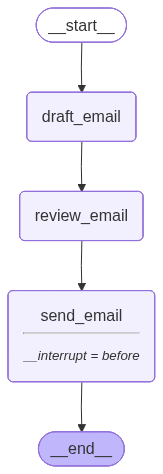

In [ ]:
# 그래프 시각화
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

## 3. 실행: 1단계 - 중단점까지 실행

In [ ]:
# 스레드 ID: 대화 세션 식별자
thread_id = "email-session-001"
config = {"configurable": {"thread_id": thread_id}}

# 초기 입력
initial_input = {
    "request": "프로젝트 진행 상황 보고 및 다음 주 미팅 요청",
    "recipient": "김팀장님",
    "subject": "",
    "body": "",
    "review_notes": "",
    "is_sent": False,
    "status": "시작"
}

print("=" * 60)
print("--1단계: 이메일 작성 및 검토 (send_email 전에 멈춤)")
print("=" * 60)

# 실행 (send_email 전에 자동으로 멈춤)
result = app.invoke(initial_input, config)

print("\n" + "=" * 60)
print("⏸️ 중단됨! 현재 상태:")
print("=" * 60)
print(f"상태: {result['status']}")
print(f"제목: {result['subject']}")
print(f"검토 노트: {result['review_notes']}")

--1단계: 이메일 작성 및 검토 (send_email 전에 멈춤)

  [draft_email] 이메일 초안 작성 중...
   제목: 프로젝트 진행 상황 보고 및 다음 주 미팅 요청
   본문 미리보기: 김팀장님께,

안녕하세요. [당신의 이름]입니다. 

현재 진행 중인 프로젝트의 상황을 보...

🔍 [review_email] 자동 검토 중...
   검토 결과: 이메일의 톤은 정중하고 전문적이며, 내용이 명확하게 전달되고 있습니다. 오타나 문법 오류는 없으며, 필요한 정보가 잘 정리되어 있어 이해하기 쉽습니다. 전체적으로 잘 작성된 이메일입니다.

⏸️ 중단됨! 현재 상태:
상태: 검토 완료 - 발송 승인 대기
제목: 프로젝트 진행 상황 보고 및 다음 주 미팅 요청
검토 노트: 이메일의 톤은 정중하고 전문적이며, 내용이 명확하게 전달되고 있습니다. 오타나 문법 오류는 없으며, 필요한 정보가 잘 정리되어 있어 이해하기 쉽습니다. 전체적으로 잘 작성된 이메일입니다.


In [ ]:
# 이메일 전문 확인
print("\n" + "=" * 60)
print("이메일 전문 (발송 전 확인)")
print("=" * 60)
print(f"수신: {result['recipient']}")
print(f"제목: {result['subject']}")
print("-" * 40)
print(result['body'])


이메일 전문 (발송 전 확인)
수신: 김팀장님
제목: 프로젝트 진행 상황 보고 및 다음 주 미팅 요청
----------------------------------------
김팀장님께,

안녕하세요. [당신의 이름]입니다. 

현재 진행 중인 프로젝트의 상황을 보고 드리고자 이메일을 작성했습니다. 현재까지의 진행 상황은 다음과 같습니다:

1. **작업 A**: 완료
2. **작업 B**: 진행 중 (예정대로 진행되고 있으며, 다음 주 중으로 마무리될 예정입니다.)
3. **작업 C**: 시작 예정 (관련 자료 수집 중)

향후 계획 및 진행 사항에 대해 논의하기 위해 다음 주에 미팅을 요청드립니다. 편하신 날짜와 시간을 말씀해 주시면 조율하겠습니다.

감사합니다.

좋은 하루 되세요.

[당신의 이름]  
[당신의 직위]  
[당신의 연락처]  
[회사명]


## 4. 실행: 2단계 - 승인 후 이어서 실행

In [ ]:
# 사용자 승인 시뮬레이션
print("\n" + "=" * 60)
print("사용자 확인")
print("=" * 60)

# 실제 앱에서는 UI를 통해 승인/거절 받음
user_decision = "승인"  # or "거절"

if user_decision == "승인":
    print("-- 사용자가 발송을 승인했습니다.")
    print("\n 이어서 실행합니다...\n")

    # ⭐ 핵심: None을 전달하면 중단점 이후부터 이어서 실행
    final_result = app.invoke(None, config)

    print("\n" + "=" * 60)
    print("-- 최종 결과")
    print("=" * 60)
    print(f"상태: {final_result['status']}")
    print(f"발송 여부: {final_result['is_sent']}")
else:
    print("❌ 사용자가 발송을 거절했습니다.")


사용자 확인
-- 사용자가 발송을 승인했습니다.

 이어서 실행합니다...


  [send_email] 이메일 발송 중...
   ----'김팀장님'에게 이메일이 발송되었습니다!
   제목: 프로젝트 진행 상황 보고 및 다음 주 미팅 요청

-- 최종 결과
상태: 발송 완료
발송 여부: True


## 5. 저장된 상태 확인하기

In [ ]:
# Checkpoint에서 상태 히스토리 확인
print("=" * 60)
print("-- 상태 히스토리 (Checkpoint)")
print("=" * 60)

for i, state in enumerate(app.get_state_history(config)):
    print(f"\n[Checkpoint {i}]")
    print(f"  다음 노드: {state.next}")
    print(f"  상태: {state.values.get('status', 'N/A')}")
    print(f"  발송 여부: {state.values.get('is_sent', 'N/A')}")

-- 상태 히스토리 (Checkpoint)

[Checkpoint 0]
  다음 노드: ()
  상태: 발송 완료
  발송 여부: True

[Checkpoint 1]
  다음 노드: ('send_email',)
  상태: 검토 완료 - 발송 승인 대기
  발송 여부: False

[Checkpoint 2]
  다음 노드: ('review_email',)
  상태: 초안 작성 완료
  발송 여부: False

[Checkpoint 3]
  다음 노드: ('draft_email',)
  상태: 시작
  발송 여부: False

[Checkpoint 4]
  다음 노드: ('__start__',)
  상태: N/A
  발송 여부: N/A


---

## 6. 상태 수정 후 재실행

In [ ]:
# 새 세션으로 시작
thread_id_2 = "email-session-002"
config_2 = {"configurable": {"thread_id": thread_id_2}}

print("=" * 60)
print("-- 새 세션: 이메일 작성")
print("=" * 60)

# 1단계 실행
result_2 = app.invoke({
    "request": "휴가 신청",
    "recipient": "인사팀",
    "subject": "",
    "body": "",
    "review_notes": "",
    "is_sent": False,
    "status": "시작"
}, config_2)

print(f"\n  작성된 제목: {result_2['subject']}")
print(f"  본문 미리보기: {result_2['body'][:100]}...")

-- 새 세션: 이메일 작성

  [draft_email] 이메일 초안 작성 중...
   제목: 휴가 신청
   본문 미리보기: 안녕하세요, 인사팀.

저는 [귀하의 이름]이며, [부서명]에서 근무하고 있습니다. 휴가를...

🔍 [review_email] 자동 검토 중...
   검토 결과: 이메일은 정중하고 명확하게 작성되어 있어 좋습니다. 필요한 정보를 잘 포함하고 있으며, 요청 사항도 분명히 전달되고 있습니다. 다만, 각 항목에 실제 정보를 빠짐없이 기입해 주시면 더욱 완벽할 것입니다. 오타는 발견되지 않았습니다.

  작성된 제목: 휴가 신청
  본문 미리보기: 안녕하세요, 인사팀.

저는 [귀하의 이름]이며, [부서명]에서 근무하고 있습니다. 휴가를 신청하고자 하여 이메일을 드립니다.

휴가 기간은 [시작일]부터 [종료일]까지 총 [일수...


In [ ]:
# --- 상태 수정: 제목 변경
print("\n" + "=" * 60)
print("-- 상태 수정: 제목 변경")
print("=" * 60)

# 현재 상태 가져오기
current_state = app.get_state(config_2)

# 상태 수정
modified_values = dict(current_state.values)
modified_values["subject"] = "[긴급] 연차 휴가 신청의 건"

# 수정된 상태 업데이트
app.update_state(config_2, modified_values)

print(f"원래 제목: {result_2['subject']}")
print(f"수정된 제목: {modified_values['subject']}")


-- 상태 수정: 제목 변경
원래 제목: 휴가 신청
수정된 제목: [긴급] 연차 휴가 신청의 건


In [ ]:
# 수정된 상태로 이어서 실행
print("\n" + "=" * 60)
print("-- 수정된 상태로 이어서 실행")
print("=" * 60)

final_result_2 = app.invoke(None, config_2)

print(f"\n  최종 발송된 제목: {final_result_2['subject']}")
print(f"  발송 완료: {final_result_2['is_sent']}")


-- 수정된 상태로 이어서 실행

  [send_email] 이메일 발송 중...
   ----'인사팀'에게 이메일이 발송되었습니다!
   제목: [긴급] 연차 휴가 신청의 건

  최종 발송된 제목: [긴급] 연차 휴가 신청의 건
  발송 완료: True


---

## 핵심

### Human-in-the-Loop 구현 3단계

```python
# 1. Checkpointer 생성
checkpointer = MemorySaver()  # 또는 SqliteSaver, PostgresSaver 등

# 2. 컴파일 시 interrupt_before 지정
app = workflow.compile(
    checkpointer=checkpointer,
    interrupt_before=["sensitive_node"]
)

# 3. 중단점 이후 재개
app.invoke(None, config)  # None 전달로 이어서 실행
```

### 주요 메서드

| 메서드 | 설명 |
|--------|------|
| `app.invoke(None, config)` | 중단점 이후 이어서 실행 |
| `app.get_state(config)` | 현재 상태 조회 |
| `app.update_state(config, values)` | 상태 수정 |
| `app.get_state_history(config)` | 상태 히스토리 조회 |

### 프로덕션 Checkpointer

```python
# SQLite (파일 저장)
from langgraph.checkpoint.sqlite import SqliteSaver
checkpointer = SqliteSaver.from_conn_string("checkpoints.db")

# PostgreSQL (서버 저장)
from langgraph.checkpoint.postgres import PostgresSaver
checkpointer = PostgresSaver.from_conn_string("postgresql://...")
```

---

## 혼자해보기 실습

### 문제 1: 거절 처리
사용자가 "거절"을 선택했을 때,  
`draft_email` 노드로 돌아가서 다시 작성하도록 수정해보세요.

### 문제 2: 다중 승인 단계
금액이 큰 결제의 경우:  
1. 팀장 승인 → 2. 부장 승인 → 3. 최종 실행  
이렇게 **2단계 승인**이 필요한 그래프를 만들어보세요.
